In [ ]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd ./drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW2

[Errno 2] No such file or directory: './drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW2'
/content/drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
real_to_label = {">50K":1,"<=50K":0}
label_to_real = {}

for key,value in real_to_label.items():
  label_to_real[value] = key

In [ ]:
# get train test data
# data cleaning
# one hot encoding (ex edu => (0,0,0,1))

def read_header(file_name):

  data = []

  with open(f"./data/{file_name}","r",newline='',encoding='big5') as file:
    csv_reader = csv.reader(file)

    for row in csv_reader:
      data.append([ele.strip() for ele in row])

  data = np.array(data)

  return data[0,:]

def read_feature(file_name):

  data = []

  csv_header = read_header(file_name)

  with open(f"./data/{file_name}","r",newline='',encoding='big5') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)

    for row in csv_reader:
      new_row = [ f"?_{csv_header[index]}" if element.strip() == "?" else element.strip() for index,element in enumerate(row)]
      data.append(new_row)

  data = np.array(data)

  return data

def read_label(file_name,read_label):

  data = []
  csv_header = read_header(file_name)

  with open(f"./data/{file_name}","r",newline='',encoding='big5') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)

    for row in csv_reader:
      data.append(real_to_label[row[14].strip()])

  data = np.array(data)

  return data


def remove_feature(data,data_header_list,remove_name_list):
  try :
    remove_index_list = [data_header_list.tolist().index(name) for name in remove_name_list]
  except :
    print("Invalid header name")
    sys.exit()

  index_list = [index for index in range(data.shape[1]) if index not in remove_index_list]
  new_data = data[:,index_list]

  return new_data


def one_hot_encoding(data):
  feature_list = []
  feature_map = {}
  int_index_list = []


  data = data.T # feature * N

  for index in range(data.shape[0]):
    try :
      int_ele = int(data[index][0])
      feature_list.append("int")
      int_index_list.append(index)
    except :
      this_feature_list = list(set(data[index,:]))
      feature_list.extend(this_feature_list)
      for feature in this_feature_list:
        feature_map[feature] = index


  new_data = []

  # print(feature_list)

  for index,feature in enumerate(feature_list):
    if feature == "int":
      original_index = int_index_list[0]
      int_index_list.pop(0)
      this_feature_data = data[original_index,:].astype(float)
      this_feature_data = (this_feature_data - this_feature_data.mean()) / this_feature_data.std()
      new_data.append(this_feature_data.tolist())

    elif feature == "Holand-Netherlands":
      pass

    else :
      original_feature_index = feature_map[feature]
      filter_feature_data = data[original_feature_index,:] == feature
      this_feature_data = [1 if bol == True else 0 for bol in filter_feature_data]
      new_data.append(this_feature_data)

  new_data = np.array(new_data).T
  return new_data

# scalize



In [ ]:


class ppl_data(Dataset):
  def __init__(self,data_list,data_label):
    self.data_list = data_list
    self.data_label = data_label

  def __getitem__(self,idx):
    return self.data_list[idx,:], self.data_label[idx]

  def __len__(self):
    return self.data_list.shape[0]

In [ ]:
train_x_raw = read_feature("train.csv")
train_x_raw = train_x_raw[:32560,:14]
test_x_raw = read_feature("test.csv")

print(train_x_raw.shape)
print(test_x_raw.shape)

data_header = read_header("test.csv")
print(len(data_header))
remove_feature_list = ["education_num"]
train_x_raw = remove_feature(train_x_raw,data_header,remove_feature_list)
test_x_raw = remove_feature(test_x_raw,data_header,remove_feature_list)

print(train_x_raw.shape)
print(test_x_raw.shape)


train_y = read_label("train.csv",real_to_label)
train_y = train_y[:32560]

print(train_y.shape)


train_x = one_hot_encoding(train_x_raw)
test_x = one_hot_encoding(test_x_raw)


train_x = np.concatenate((train_x,np.ones(train_x.shape[0])[:,None]),axis=1)
test_x = np.concatenate((test_x,np.ones(test_x.shape[0])[:,None]),axis=1)

print(train_x.shape)
print(test_x.shape)

# 統一用 train feature list


(32560, 14)
(16281, 14)
14
(32560, 13)
(16281, 13)
(32560,)
(32560, 107)
(16281, 107)


In [ ]:
import math
val_rate = 0.2
val_index = int(math.floor(train_x.shape[0] * 0.2))

val_x = train_x[:val_index,:]
val_y = train_y[:val_index]

train_x = train_x[val_index:,:]
train_y = train_y[val_index:]

In [ ]:
train_data_set = ppl_data(train_x,train_y)
val_data_set = ppl_data(val_x,val_y)

train_data_loader = DataLoader(train_data_set, batch_size=16,shuffle=True)
val_data_loader = DataLoader(val_data_set,batch_size=16,shuffle=False)

In [ ]:
class ppl_model(nn.Module):
  def __init__(self,feature_len):
    super(ppl_model,self).__init__()
    self.linear1 = nn.Linear(feature_len,50)
    self.dropout1 = nn.Dropout(0.5)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(50,1)
    self.dropout2 = nn.Dropout(0.5)
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(30,1)
    self.dropout3 = nn.Dropout(0.5)
    self.sigmoid = nn.Sigmoid()
    self.net = nn.Sequential(
        self.linear1,
        self.dropout1,
        self.relu1,
        self.linear2,
        self.dropout2,
        # self.relu2,
        # self.linear3,
        # self.dropout3,
        self.sigmoid
    )

  def forward(self,x):
    return self.net(x)

In [ ]:

model_name = "" #@param {type:"string"}

epoch = 30 #@param {type:"integer"}

learning_rate = 0.1 #@param {type:"number"}


optim_method = "sgd" #@param ["sgd","adam","rmsprop"]




In [ ]:
## 用 os find 是否有同名 model 發出警告

In [ ]:
import torch

model = ppl_model(train_x.shape[1])
model.to(torch.device("cpu"))
loss_function = nn.CrossEntropyLoss()

if optim_method == "sgd":
  optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
elif optim_method == "adam":
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
elif optim_method == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate)
else :
  raise Exception("Invalid optimizer")

In [ ]:

total_train_loss_list = []
total_train_acc_list = []
total_test_loss_list = []
total_test_acc_list = []

for i in tqdm(range(epoch)):
  train_loss_list = []
  train_acc_list = []
  test_loss_list = []
  test_acc_list = []


  for batch_train_x, batch_train_y in train_data_loader:

    model.train()
    optimizer.zero_grad()
    batch_train_x = batch_train_x.to(torch.float32).to(torch.device("cpu"))
    batch_train_y = batch_train_y.to(torch.float32).to(torch.device("cpu"))
    hypo_y = model(batch_train_x).squeeze()
    loss = loss_function(hypo_y,batch_train_y)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      hypo_y = model(batch_train_x).squeeze()
      loss = loss_function(hypo_y,batch_train_y)
      train_loss_list.append(loss.item())
      acc_hypo = (hypo_y >= 0.5).to(int)
      train_acc = np.count_nonzero(acc_hypo == batch_train_y) / hypo_y.shape[0]
      train_acc_list.append(train_acc)

  train_loss_list = np.array(train_loss_list)
  total_train_loss_list.append(train_loss_list.mean())
  train_acc_list = np.array(train_acc_list)
  total_train_acc_list.append(train_acc_list.mean())

  model.eval()
  for batch_val_x, batch_val_y in val_data_loader:
    batch_val_x = batch_val_x.to(torch.float32).to(torch.device("cpu"))
    batch_val_y = batch_val_y.to(torch.float32).to(torch.device("cpu"))

    with torch.no_grad():
      hypo_y = model(batch_val_x).squeeze()
      loss = loss_function(hypo_y,batch_val_y)
      test_loss_list.append(loss.item())

      acc_hypo = (hypo_y >= 0.5).to(int)
      test_acc = np.count_nonzero(acc_hypo == batch_val_y) / hypo_y.shape[0]
      test_acc_list.append(test_acc)

  test_loss_list = np.array(test_loss_list)
  total_test_loss_list.append(test_loss_list.mean())
  test_acc_list = np.array(test_acc_list)
  total_test_acc_list.append(test_acc_list.mean())


## 記下最佳 model、 acc 與 loss

100%|██████████| 30/30 [01:47<00:00,  3.57s/it]


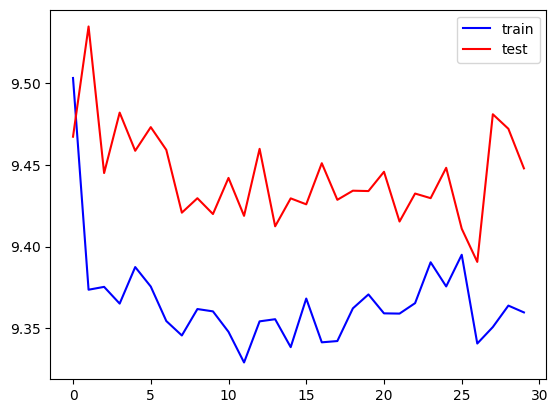

In [ ]:
plt.plot(range(epoch),total_train_loss_list,"b",label="train")
plt.plot(range(epoch),total_test_loss_list,"r",label="test")
plt.legend()
plt.show()

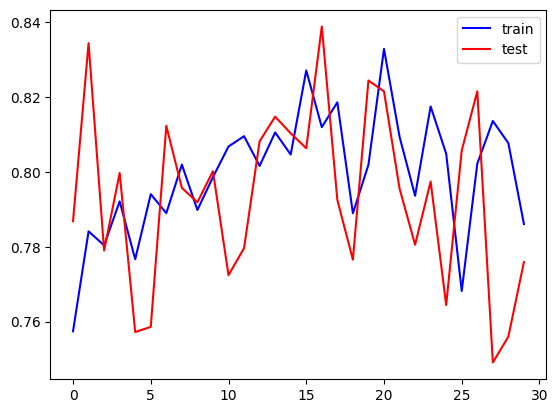

In [ ]:
plt.plot(range(epoch),total_train_acc_list,"b",label="train")
plt.plot(range(epoch),total_test_acc_list,"r",label="test")
plt.legend()
plt.show()

In [ ]:
semi_epoch = 30 #@param {type:"integer"}

In [ ]:

model_name = "" #@param {type:"string"}

semi_learning_rate = 0.3 #@param {type:"number"}

semi_optim_method = "rmsprop" #@param ["sgd","adam","rmsprop"]




In [ ]:
import torch

loss_function = nn.CrossEntropyLoss()

if semi_optim_method == "sgd":
  optimizer = torch.optim.SGD(model.parameters(),lr=semi_learning_rate)
elif semi_optim_method == "adam":
  optimizer = torch.optim.Adam(model.parameters(),lr=semi_learning_rate)
elif semi_optim_method == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(),lr=semi_learning_rate)
else :
  raise Exception("Invalid optimizer")

In [ ]:

total_train_loss_list = []
total_train_acc_list = []
total_test_loss_list = []
total_test_acc_list = []

for iterate_index in tqdm(range(semi_epoch)):
  train_loss_list = []
  train_acc_list = []
  test_loss_list = []
  test_acc_list = []

  model.eval()
  with torch.no_grad():
    test_hypo_y = model(torch.tensor(test_x).to(torch.float32)).squeeze()

  test_hypo_y = (test_hypo_y >= 0.5).to(int).numpy()

  semi_train_x = np.concatenate((train_x,test_x),axis=0)
  semi_train_y = np.concatenate((train_y,test_hypo_y),axis=0)

  semi_train_data_set = ppl_data(semi_train_x,semi_train_y)
  semi_train_data_loader = DataLoader(semi_train_data_set, batch_size=16,shuffle=True)

  model.train()




  for batch_train_x, batch_train_y in semi_train_data_loader:
    batch_train_x = batch_train_x.to(torch.float32).to(torch.device("cpu"))
    batch_train_y = batch_train_y.to(torch.float32).to(torch.device("cpu"))
    optimizer.zero_grad()
    batch_hypo_y = model(batch_train_x).squeeze()
    loss = loss_function(batch_hypo_y,batch_train_y)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      hypo_y = model(batch_train_x).squeeze()
      loss = loss_function(hypo_y,batch_train_y)
      train_loss_list.append(loss.item())
      acc_hypo = (hypo_y >= 0.5).to(int)
      train_acc = np.count_nonzero(acc_hypo == batch_train_y) / hypo_y.shape[0]
      train_acc_list.append(train_acc)

  train_loss_list = np.array(train_loss_list)
  total_train_loss_list.append(train_loss_list.mean())
  train_acc_list = np.array(train_acc_list)
  total_train_acc_list.append(train_acc_list.mean())


  model.eval()
  for batch_val_x, batch_val_y in val_data_loader:
    batch_val_x = batch_val_x.to(torch.float32).to(torch.device("cpu"))
    batch_val_y = batch_val_y.to(torch.float32).to(torch.device("cpu"))

    with torch.no_grad():
      hypo_y = model(batch_val_x).squeeze()
      loss = loss_function(hypo_y,batch_val_y)
      test_loss_list.append(loss.item())

      acc_hypo = (hypo_y >= 0.5).to(int)
      test_acc = np.count_nonzero(acc_hypo == batch_val_y) / hypo_y.shape[0]
      test_acc_list.append(test_acc)

  test_loss_list = np.array(test_loss_list)
  total_test_loss_list.append(test_loss_list.mean())
  test_acc_list = np.array(test_acc_list)
  total_test_acc_list.append(test_acc_list.mean())



100%|██████████| 30/30 [03:00<00:00,  6.03s/it]


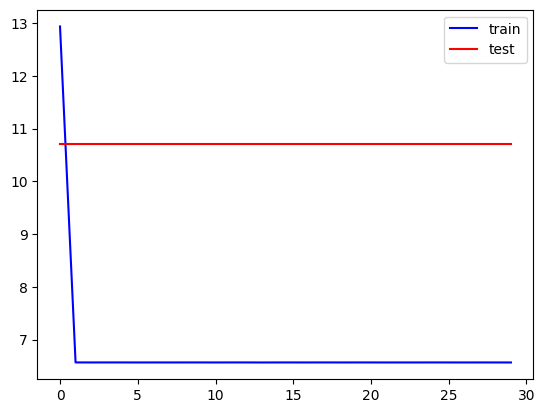

In [ ]:
plt.plot(range(semi_epoch),total_train_loss_list,"b",label="train")
plt.plot(range(semi_epoch),total_test_loss_list,"r",label="test")
plt.legend()
plt.show()

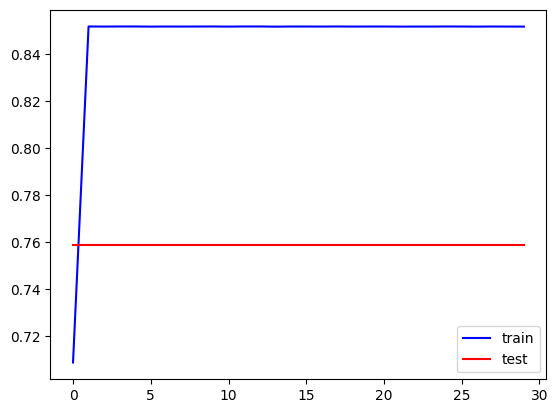

In [ ]:
plt.plot(range(semi_epoch),total_train_acc_list,"b",label="train")
plt.plot(range(semi_epoch),total_test_acc_list,"r",label="test")
plt.legend()
plt.show()

In [ ]:
model_name = "adam"

In [ ]:
torch.save(model.state_dict(),model_name)

In [ ]:
## 用 pandas 紀錄各個成績

In [ ]:
## 印出 pandas